# Import Libraries

In [6]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from prettytable import PrettyTable
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.base import clone, BaseEstimator, TransformerMixin
from category_encoders import TargetEncoder
from catboost import CatBoostRegressor
import warnings

# Reproducibility setup
RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Visualization and warning settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_rows", 100)

# Constants
FILE_PATH = ""
TARGET = "TARGET"
n_splits = 5

# Load Data

In [105]:
# load all data
train = pd.read_csv(os.path.join(FILE_PATH, "train.csv"))
test = pd.read_csv(os.path.join(FILE_PATH, "test.csv"))
sample_sub = pd.read_csv(os.path.join(FILE_PATH, "sample_submission.csv"))

In [106]:
train

,sessionID,userID,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,SESSION_000000,USER_000000,17.0,Chrome,Macintosh,desktop,0,45.0,839.0,0,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
1,SESSION_000001,USER_000001,3.0,Chrome,Windows,desktop,1,1.0,39.0,0,0.0,0.0,Europe,Western Europe,Germany,google,organic,Category8,NaN
2,SESSION_000002,USER_000002,1.0,Samsung Internet,Android,mobile,1,1.0,0.0,1,0.0,0.0,Asia,Southeast Asia,Malaysia,(direct),(none),NaN,NaN
3,SESSION_000003,USER_000003,1.0,Chrome,Macintosh,desktop,1,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,Partners,affiliate,NaN,NaN
4,SESSION_000004,USER_000004,1.0,Chrome,iOS,mobile,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,groups.google.com,referral,NaN,Category6_Path_0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252284,SESSION_252284,USER_206021,1.0,Chrome,Android,mobile,1,1.0,0.0,1,0.0,0.0,Europe,Northern Europe,United Kingdom,youtube.com,referral,NaN,Category5_Path_0032
252285,SESSION_252285,USER_206022,1.0,Chrome,Macintosh,desktop,0,1.0,0.0,1,0.0,0.0,Americas,Northern America,United States,google,organic,Category8,NaN
252286,SESSION_252286,USER_164240,5.0,Chrome,Macintosh,desktop,0,2.0,69.0,0,0.0,0.0,Americas,Northern America,United States,(direct),(none),NaN,Category1
252287,SESSION_252287,USER_206023,1.0,Android Webview,Android,mobile,1,1.0,28.0,0,0.0,0.0,Africa,Northern Africa,Egypt,youtube.com,referral,NaN,Category2_Path_0018


In [107]:
class ColumnEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit_transform(self, X, y=None):
        self.encoders = {}
        for col in self.cols:
            le = TargetEncoder()
            X[col] = le.fit_transform(X[col], y)
            self.encoders[col] = le
        return X
    
    def transform(self, X):
        for col in self.cols:
            X[col] = self.encoders[col].transform(X[col])
        return X

# EDA

min: 1.0, max: 386.0


<Axes: xlabel='TARGET', ylabel='Count'>

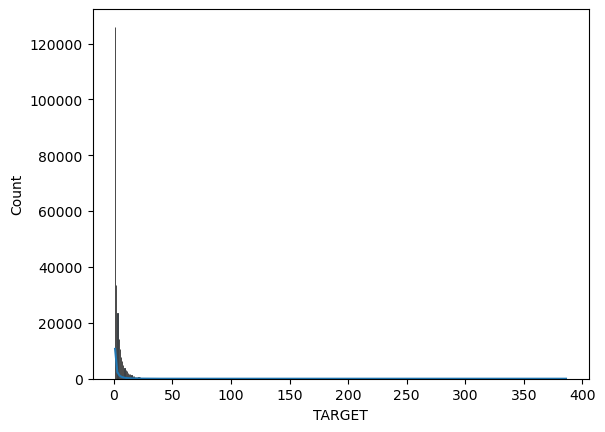

In [117]:
# Target의 분포를 확인합니다.
print(f'min: {train[TARGET].min()}, max: {train[TARGET].max()}')
sns.histplot(train[TARGET], linewidth=0.5, kde=True)

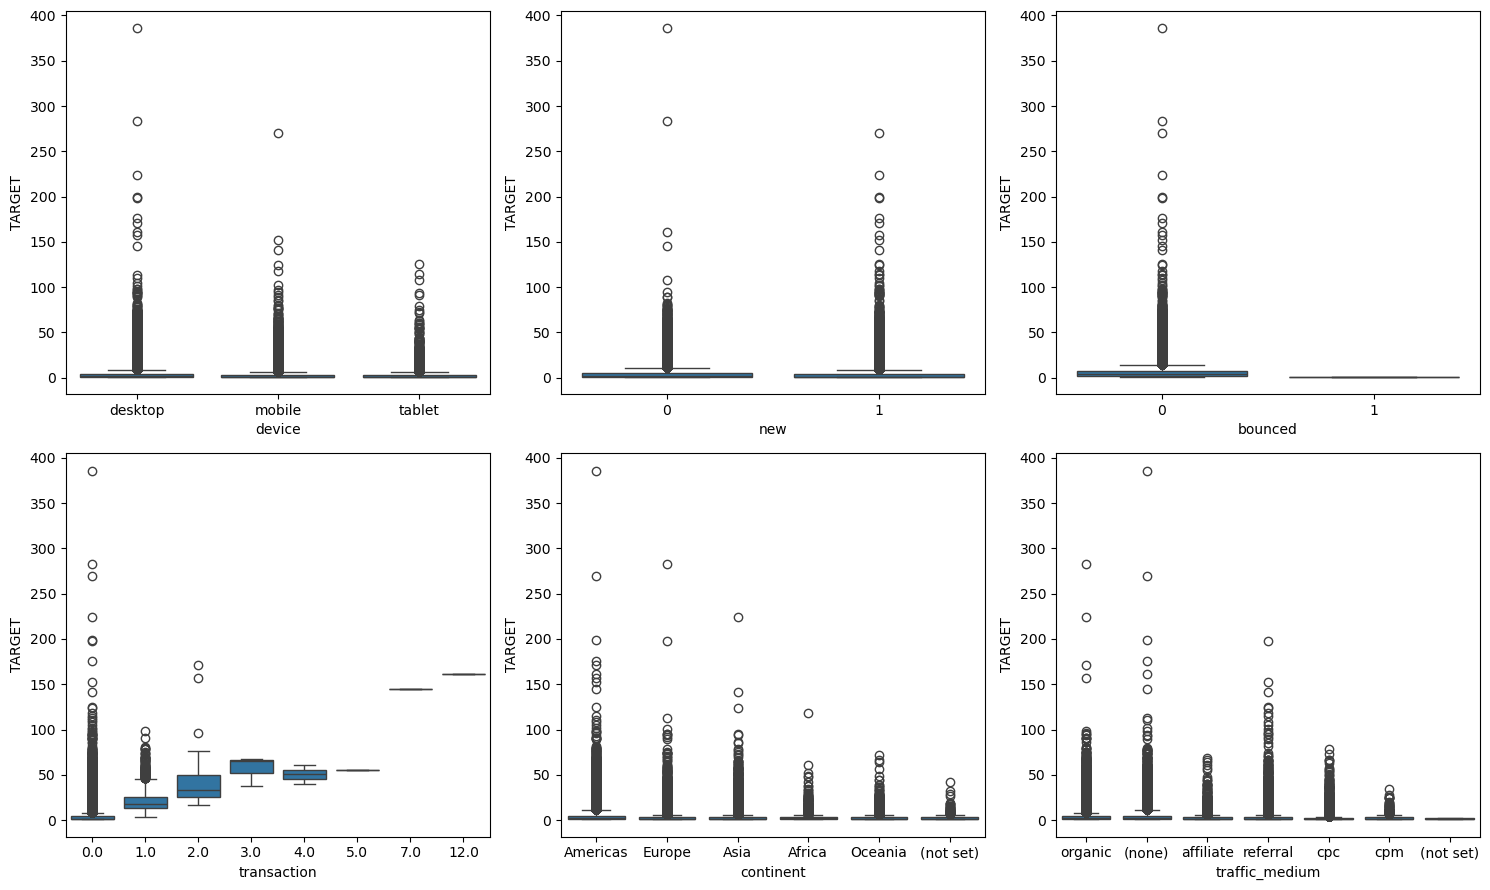

In [109]:
# train에서 컬럼의 unique한 값의 개수가 20개 이하인 컬럼만 선택
selected_cols = [col for col in train.columns if len(train[col].unique()) <= 20]
# target과의 관계를 살펴보기 위해, target을 분리하여 데이터를 분석
train_eda = train[selected_cols + [TARGET]].copy()

plt.figure(figsize=(15, 9))
for i, col in enumerate(selected_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=col, y=TARGET, data=train_eda)
    plt.tight_layout()

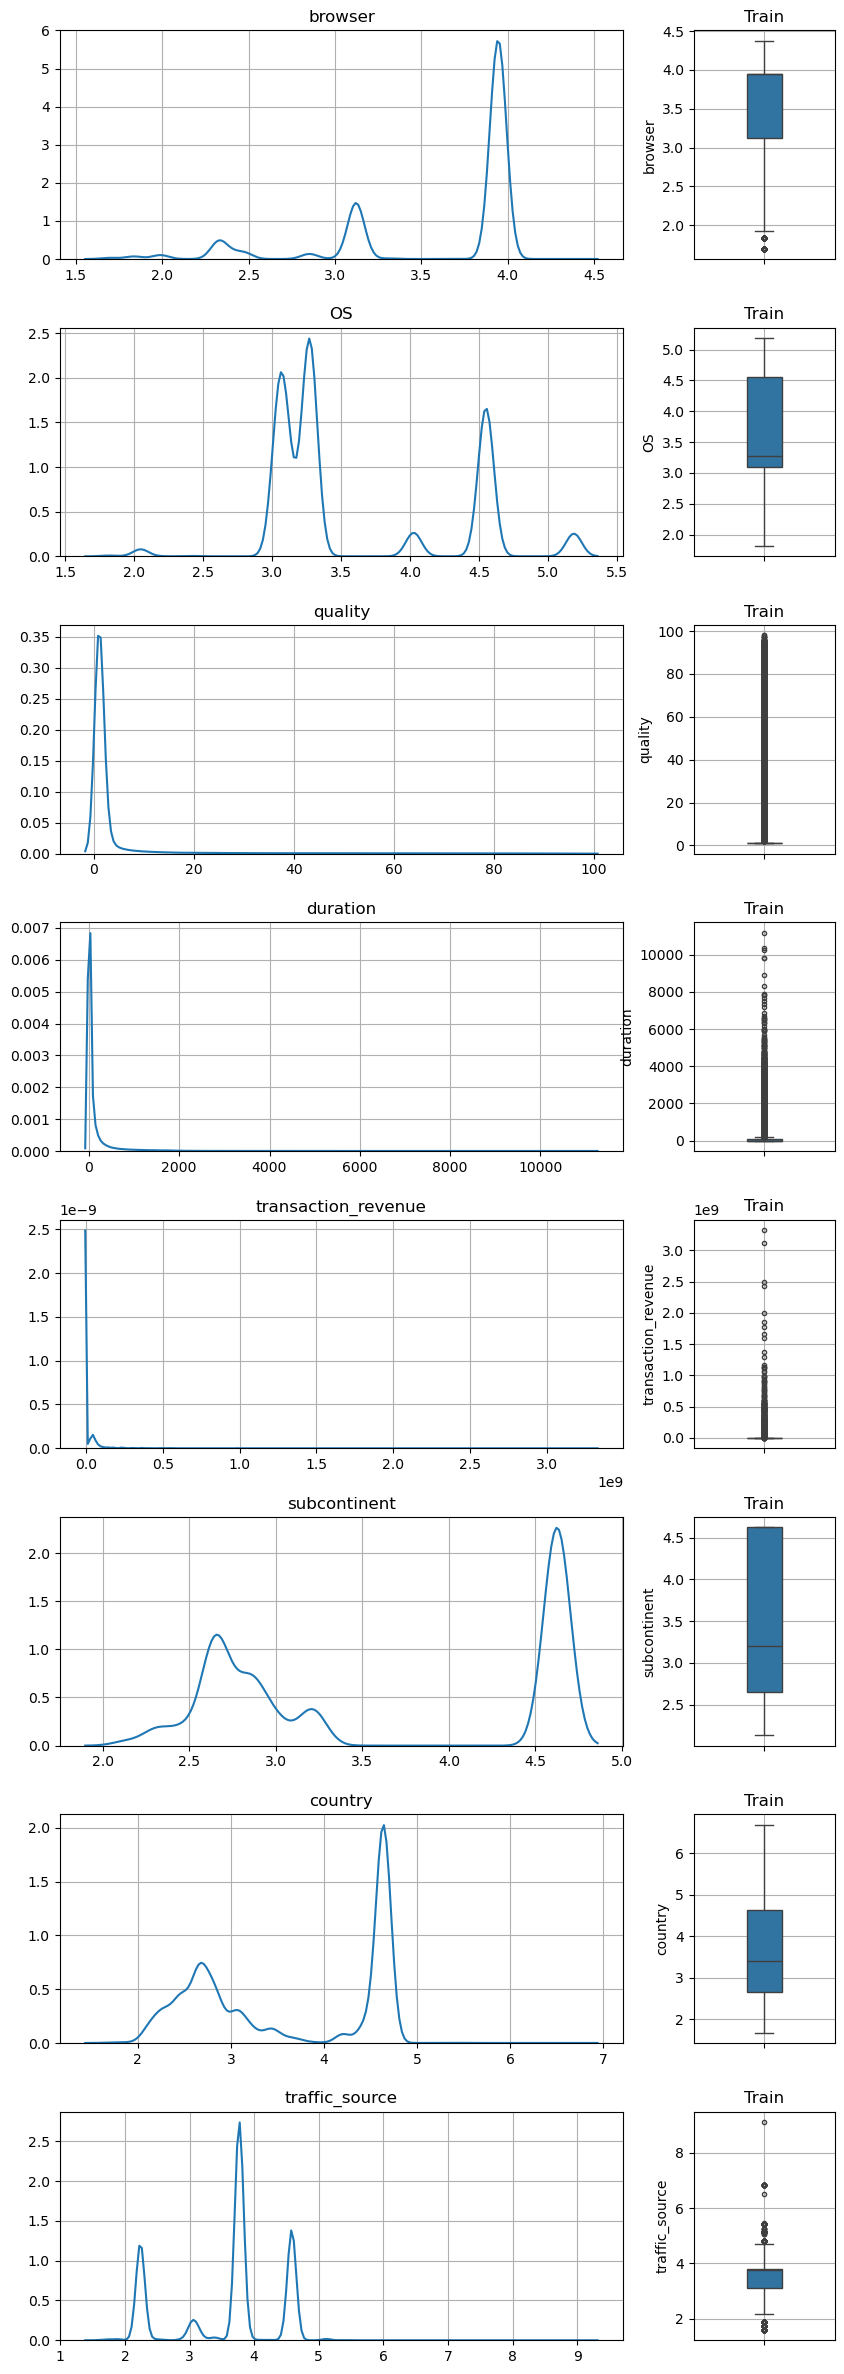

In [110]:
selected_cols = [col for col in train.columns if len(train[col].unique()) >= 20 and col not in ['sessionID', 'userID', 'keyword', 'referral_path']]
train_eda = train[selected_cols].copy()

ce = ColumnEncoder(train_eda.columns[1:])
train_eda = ce.fit_transform(train_eda, train_eda[TARGET])

selected_cols.remove('TARGET')

fig, axes = plt.subplots(len(selected_cols), 2, figsize=(10, 30), gridspec_kw={'hspace': 0.3, 'wspace': 0.2, 'width_ratios': [0.8, 0.2]})
for i, col in enumerate(selected_cols):
    sns.kdeplot(train_eda[col], ax=axes[i, 0])
    axes[i, 0].set_title(col)
    axes[i, 0].grid(True)
    axes[i, 0].set(ylabel='', xlabel='')

    sns.boxplot(y=col, data=train_eda, ax=axes[i, 1], width=0.25, fliersize=3)
    axes[i, 1].set_title('Train')
    axes[i, 1].grid(True)

    plt.tight_layout()

# Explore Data

In [74]:
def prettify_df(df):
    table = PrettyTable()
    table.field_names = df.columns

    for row in df.values:
        table.add_row(row)
    print(table)

In [75]:
# Train Data
print("Train Data")
print(f"Total number of rows: {len(train)}")
print(f"Total number of columns: {train.shape[1]}\n")

# Test Data
print("Test Data")
print(f"Total number of rows: {len(test)}")
print(f"Total number of columns:{test.shape[1]}")

Train Data
Total number of rows: 252289
Total number of columns: 19

Test Data
Total number of rows: 79786
Total number of columns:18


# Feature Engineering & Processing

In [76]:
skf = StratifiedKFold(n_splits=n_splits)

def cross_val_model(train, estimators,cv = skf, verbose = True):
    X = train[train['bounced'] == 0].copy()
    y = X.pop(TARGET)

    test_predictions = np.zeros((len(test)))

    val_scores = []
    for fold, (train_ind, valid_ind) in enumerate(skf.split(X,y, groups=X['userID'])):
        model = clone(estimators)
        
        X_train, y_train = X.iloc[train_ind].drop('userID', axis = 1), y.iloc[train_ind]
        X_valid, y_valid = X.iloc[valid_ind].drop('userID', axis = 1), y.iloc[valid_ind]
        
        model.fit(X_train, y_train)

        if verbose:
            print("-" * 100)
            print(f"Fold: {fold}")

            y_preds_t = model.predict(X_train)
            y_preds_t[y_preds_t < 1] = 1
            
            y_preds_v = model.predict(X_valid)
            y_preds_v[y_preds_v < 1] = 1

            print(f"Train Accuracy Score:-{mean_squared_error(y_train, y_preds_t, squared=False)}")
            print(f"Valid Accuracy Score:-{mean_squared_error(y_valid, y_preds_v, squared=False)}")
            print("-" * 100)

        test_predictions += model.predict(test) / n_splits
        y_preds = model.predict(X_valid)
        y_preds[y_preds < 1] = 1
        y_preds[X_valid['bounced'] == 1] = 1

        val_scores.append(mean_squared_error(y_valid,y_preds, squared=False))

    if verbose: 
        print(f"RMSE Score: {np.array(val_scores).mean()}")

    test_predictions[test_predictions < 1] = 1
    test_predictions[test['bounced'] == 1] = 1
    
    return val_scores, test_predictions

In [77]:
# 불필요한 컬럼 제거 및 중복 데이터 제거
drop_cols = ['sessionID', 'keyword', 'referral_path', 'transaction_revenue']
train.drop(drop_cols, axis = 1, inplace = True)
test.drop(drop_cols, axis = 1, inplace = True)

train = train.drop_duplicates()
train.reset_index(drop=True, inplace=True)

In [78]:
for df in [train, test]:
    df['transaction_rate'] = df.apply(lambda x: x['transaction'] / x['duration'] if x['duration'] > 0 else 0, axis=1)

    # 기술적 환경 기반 파생 변수 생성
    df['device_quality'] = df['device'] + '_' + df['quality'].astype(str)

    # 지역 및 트래픽 소스 기반 파생 변수 생성
    df['continent_subcontinent'] = df['continent'] + '_' + df['subcontinent']
    df['traffic_source_medium'] = df['traffic_source'] + '_' + df['traffic_medium']

In [79]:
# null 및 고유 카운트 확인
train_copy = train.copy()
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
# tmp에서 column type이 object가 아닌 것의 최소를 구하기, column type이 object이면 'no'로 채움
tmp['min'] = [train_copy[col].min() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp['max'] = [train_copy[col].max() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp, train_copy

+------------------------+--------+---------+---------+----------+-------+-----+---------+
|      Column Name       | count  |  dtype  | nunique | %nunique | %null | min |   max   |
+------------------------+--------+---------+---------+----------+-------+-----+---------+
|         userID         | 244283 |  object |  206024 |  84.338  |  0.0  | nan |   nan   |
|         TARGET         | 244283 | float64 |   117   |  0.048   |  0.0  | 1.0 |  386.0  |
|        browser         | 244283 |  object |    70   |  0.029   |  0.0  | nan |   nan   |
|           OS           | 244283 |  object |    21   |  0.009   |  0.0  | nan |   nan   |
|         device         | 244283 |  object |    3    |  0.001   |  0.0  | nan |   nan   |
|          new           | 244283 |  int64  |    2    |  0.001   |  0.0  | 0.0 |   1.0   |
|        quality         | 244283 | float64 |    98   |   0.04   |  0.0  | 1.0 |   98.0  |
|        duration        | 244283 | float64 |   2972  |  1.217   |  0.0  | 0.0 | 11186.0 |

In [80]:
# column encoder
categorical_columns = train.select_dtypes(include=['object']).columns

train = train.copy()
ce = ColumnEncoder(categorical_columns)
train = ce.fit_transform(train, train[TARGET])
test = ce.transform(test)

In [81]:
# null 및 고유 카운트 확인
train_copy = train.copy()
tmp = pd.DataFrame(index=train_copy.columns)
tmp['count'] = train_copy.count()
tmp['dtype'] = train_copy.dtypes
tmp['nunique'] = train_copy.nunique()
tmp['%nunique'] = (tmp['nunique']/len(train_copy))*100
tmp['%null'] = (train_copy.isnull().sum()/len(train_copy))*100
# tmp에서 column type이 object가 아닌 것의 최소를 구하기, column type이 object이면 'no'로 채움
tmp['min'] = [train_copy[col].min() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp['max'] = [train_copy[col].max() if train_copy[col].dtype != 'object' else None for col in train_copy.columns]
tmp

tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {"index":"Column Name"})
tmp = tmp.round(3)
prettify_df(tmp)
del tmp, train_copy

+------------------------+--------+---------+---------+----------+-------+-------+---------+
|      Column Name       | count  |  dtype  | nunique | %nunique | %null |  min  |   max   |
+------------------------+--------+---------+---------+----------+-------+-------+---------+
|         userID         | 244283 | float64 |   844   |  0.346   |  0.0  | 2.554 |  38.328 |
|         TARGET         | 244283 | float64 |   117   |  0.048   |  0.0  |  1.0  |  386.0  |
|        browser         | 244283 | float64 |    35   |  0.014   |  0.0  | 1.701 |  4.447  |
|           OS           | 244283 | float64 |    19   |  0.008   |  0.0  | 1.821 |  5.337  |
|         device         | 244283 | float64 |    3    |  0.001   |  0.0  | 3.051 |  3.962  |
|          new           | 244283 |  int64  |    2    |  0.001   |  0.0  |  0.0  |   1.0   |
|        quality         | 244283 | float64 |    98   |   0.04   |  0.0  |  1.0  |   98.0  |
|        duration        | 244283 | float64 |   2972  |  1.217   |  0.

<a id = "cat"></a>
# Catboost Model


In [82]:
def objective(trial):
    params = {
        "iterations": 1000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e2, log=True),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 0, 25),
        "random_state": RANDOM_SEED,
        "verbose": 0,
        "loss_function": "RMSE",
    }
    
    model = make_pipeline(
        CatBoostRegressor(**params)
        )
    
    val_scores, _ = cross_val_model(train, model, verbose=False)
    return np.mean(val_scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1000)

In [90]:
best_params = study.best_params
best_params["random_state"] = RANDOM_SEED
best_params["verbose"] = 0
best_params["iterations"] = 1000
best_params["loss_function"] = "RMSE"

CB = make_pipeline(
    CatBoostRegressor(**best_params)
    )

In [ ]:
# Train Catboost Model
_, test_predictions = cross_val_model(train, CB)

# Submission

In [ ]:
sample_sub[TARGET] = test_predictions
sample_sub.to_csv("optuna_submission.csv", index=False)